SparkSession created with version: 3.5.0


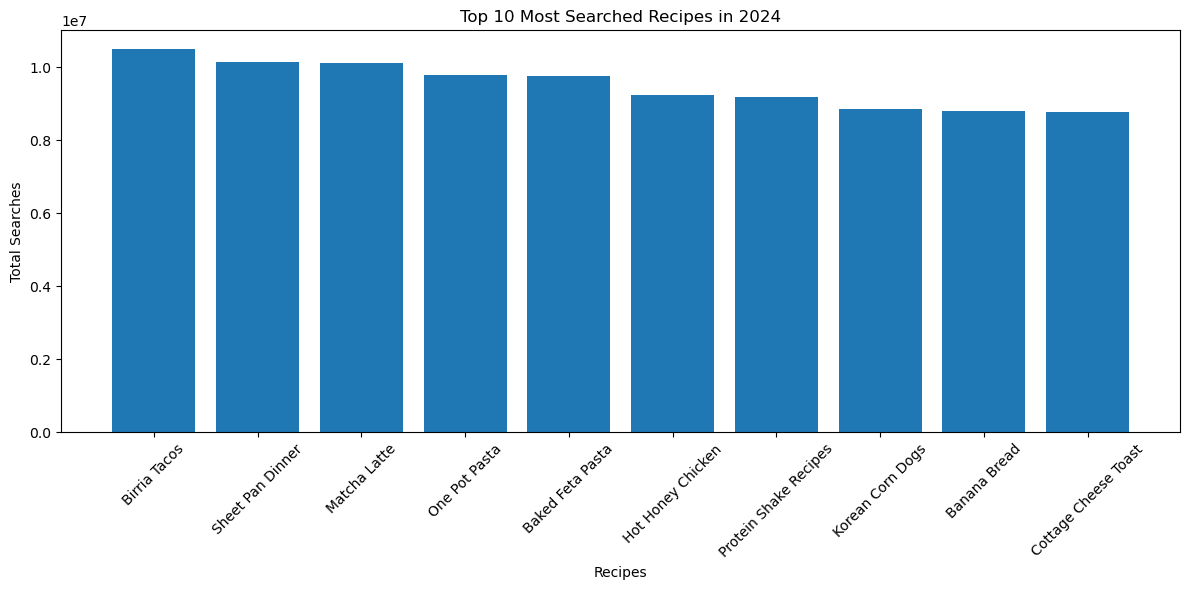

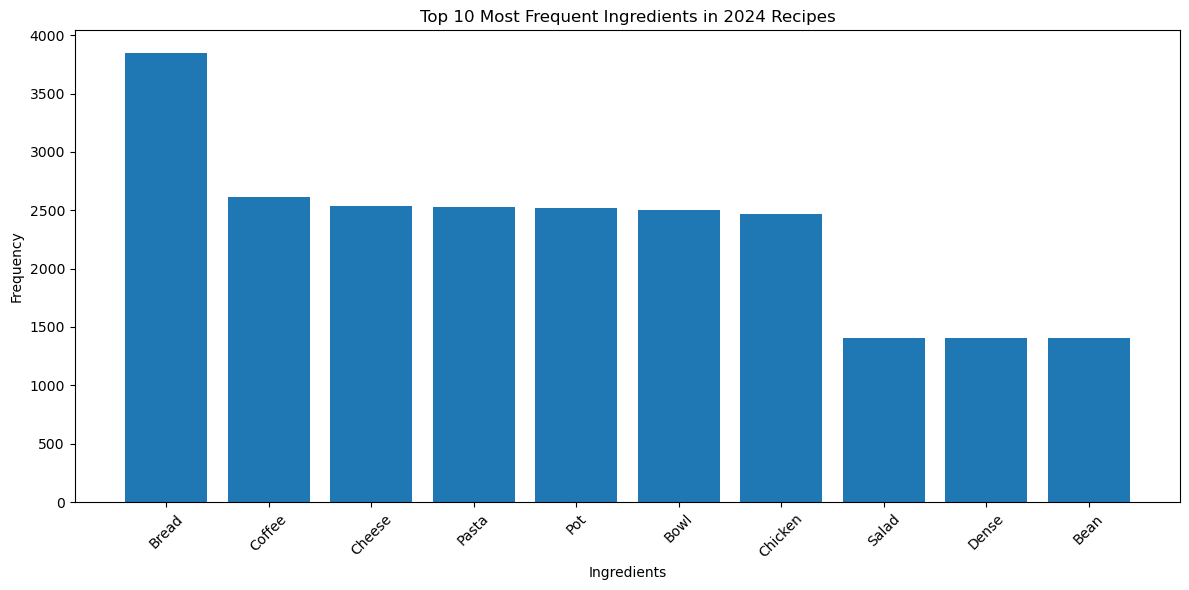

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, col

def get_spark_session():
    spark = SparkSession.builder \
        .appName("RecipeAnalysis2024") \
        .master("spark://spark-master:7070") \
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
        .config("spark.mongodb.input.uri", "mongodb://mongo_db:27017/holiday_db.recipes_2024") \
        .config("spark.mongodb.output.uri", "mongodb://mongo_db:27017/holiday_db.results") \
        .getOrCreate()
    print("SparkSession created with version:", spark.version)
    return spark

spark = get_spark_session()

# Đọc dữ liệu từ MongoDB
df = spark.read.format("mongo").load()

# Top 10 công thức tìm kiếm nhiều nhất dựa trên keyword
top_recipes = df.groupBy("keyword") \
                .sum("search_vol") \
                .withColumnRenamed("sum(search_vol)", "total_searches") \
                .orderBy("total_searches", ascending=False) \
                .limit(10)
top_recipes_pd = top_recipes.toPandas()

# Top 10 nguyên liệu phổ biến nhất từ recipe
ingredients_df = df.select(explode("recipe").alias("ingredient")) \
                  .groupBy("ingredient") \
                  .count() \
                  .orderBy("count", ascending=False) \
                  .limit(10)
ingredients_pd = ingredients_df.toPandas()

# Trực quan hóa top công thức
plt.figure(figsize=(12, 6))
plt.bar(top_recipes_pd['keyword'], top_recipes_pd['total_searches'])
plt.xticks(rotation=45)
plt.xlabel("Recipes")
plt.ylabel("Total Searches")
plt.title("Top 10 Most Searched Recipes in 2024")
plt.tight_layout()
plt.show()

# Trực quan hóa top nguyên liệu
plt.figure(figsize=(12, 6))
plt.bar(ingredients_pd['ingredient'], ingredients_pd['count'])
plt.xticks(rotation=45)
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Ingredients in 2024 Recipes")
plt.tight_layout()
plt.show()

In [4]:
# spark.stop()